In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from acoustics.octave import Octave
from scipy.signal import firwin2, freqz
import utils

In [2]:
sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = [16, 8]

In [3]:
ref_filename = 'audio/beh_simul.wav'
dut_filename = 'audio/43434_simul.wav'

In [4]:
ref_file_sr = librosa.get_samplerate(ref_filename)
dut_file_sr = librosa.get_samplerate(dut_filename)
y_ref, sr_ref = librosa.load(ref_filename, sr=ref_file_sr)
y_dut, sr_dut = librosa.load(dut_filename, sr=dut_file_sr)
print('Ref sample rate: %i Hz' % sr_ref)
print('Ref sample count: %i' % len(y_ref))
print()
print('DUT sample rate: %i Hz' % sr_dut)
print('DUT sample count: %i' % len(y_dut))

Ref sample rate: 48000 Hz
Ref sample count: 1051347

DUT sample rate: 48000 Hz
DUT sample count: 1051347


In [5]:
window_ref = np.hanning(len(y_ref))
window_dut = np.hanning(len(y_dut))
windowed_samples_ref = window_ref * y_ref
windowed_samples_dut = window_dut * y_dut

In [6]:
nfft_ref = len(windowed_samples_ref)
nfft_dut = len(windowed_samples_dut)
X_ref = np.fft.rfft(windowed_samples_ref, n=nfft_ref)
X_dut = np.fft.rfft(windowed_samples_dut, n=nfft_dut)

In [7]:
mag_spec_lin_ref = [np.sqrt(i.real ** 2 + i.imag ** 2) / len(X_ref) for i in X_ref]
mag_spec_lin_dut = [np.sqrt(i.real ** 2 + i.imag ** 2) / len(X_dut) for i in X_dut]

In [8]:
freq_array_ref = np.linspace(0, sr_ref / 2, num=len(mag_spec_lin_ref))
freq_array_dut = np.linspace(0, sr_dut / 2, num=len(mag_spec_lin_dut))

In [9]:
def octsmooth(amps, freq_array, noct, sr):
    o = Octave(fmin=20, fmax=20000, fraction=noct)
    octbins = np.zeros(len(o.center))
    for i in range(0, len(o.center)):
        st = (np.abs(freq_array - o.lower[i])).argmin()
        en = (np.abs(freq_array - o.upper[i])).argmin()
        window = np.hanning(en - st)
        octbinvec = window * amps[st:en]
        octbins[i] = np.max(octbinvec)
    return octbins, o.center

In [10]:
octave_smooth = 4

In [11]:
magspec_lin_smoothed_ref, freq_smoothed_ref = octsmooth(mag_spec_lin_ref, freq_array_ref, octave_smooth, sr_ref)
magspec_lin_smoothed_dut, freq_smoothed_dut = octsmooth(mag_spec_lin_dut, freq_array_dut, octave_smooth, sr_dut)

In [12]:
magspec_db_smoothed_ref = 20 * np.log10(magspec_lin_smoothed_ref)
magspec_db_smoothed_dut = 20 * np.log10(magspec_lin_smoothed_dut)

In [13]:
# magspec_db_smoothed_ref = magspec_lin_smoothed_ref
# magspec_db_smoothed_dut = magspec_lin_smoothed_dut

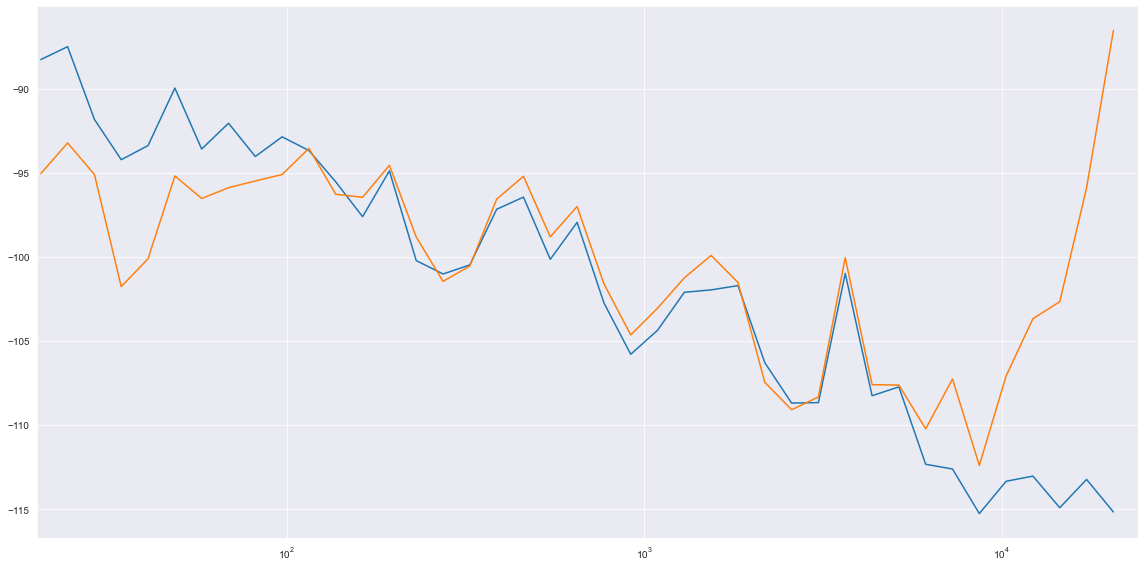

In [14]:
plt.semilogx(freq_smoothed_ref, magspec_db_smoothed_ref, freq_smoothed_dut, magspec_db_smoothed_dut)
plt.xlim([20, 24000])
plt.tight_layout()

In [33]:
magspec_db_smoothed_diff = magspec_db_smoothed_ref - magspec_db_smoothed_dut
align_freq = 1000
freq_idx = np.abs(freq_smoothed_ref - align_freq).argmin()
magspec_db_smoothed_diff = magspec_db_smoothed_diff - magspec_db_smoothed_diff[freq_idx]

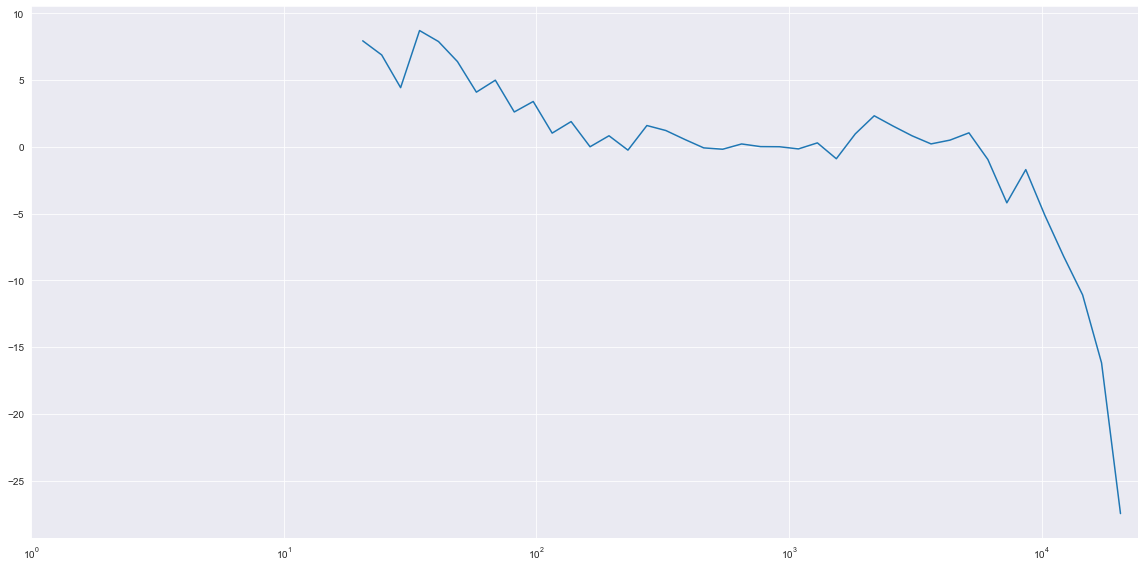

In [34]:
plt.semilogx(freq_smoothed_ref, magspec_db_smoothed_diff)
plt.xlim([1, 24000])
plt.tight_layout()

In [35]:
freq_smoothed_aug = np.append(np.insert(freq_smoothed_ref, 0, [0]), sr_ref/2)
magspec_db_smoothed_diff_aug = np.append(np.insert(magspec_db_smoothed_diff, 0, [0]), magspec_db_smoothed_diff[-1])

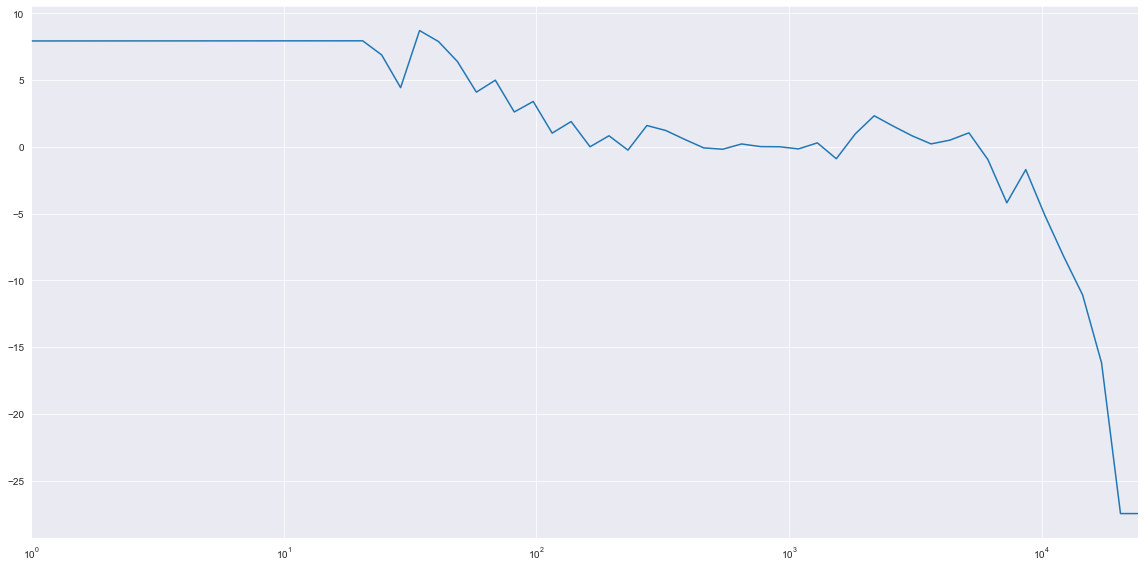

In [36]:
plt.semilogx(freq_smoothed_aug, magspec_db_smoothed_diff_aug)
plt.xlim([1, 24000])
plt.tight_layout()

In [37]:
filt_gains = 10**(magspec_db_smoothed_diff_aug/20)

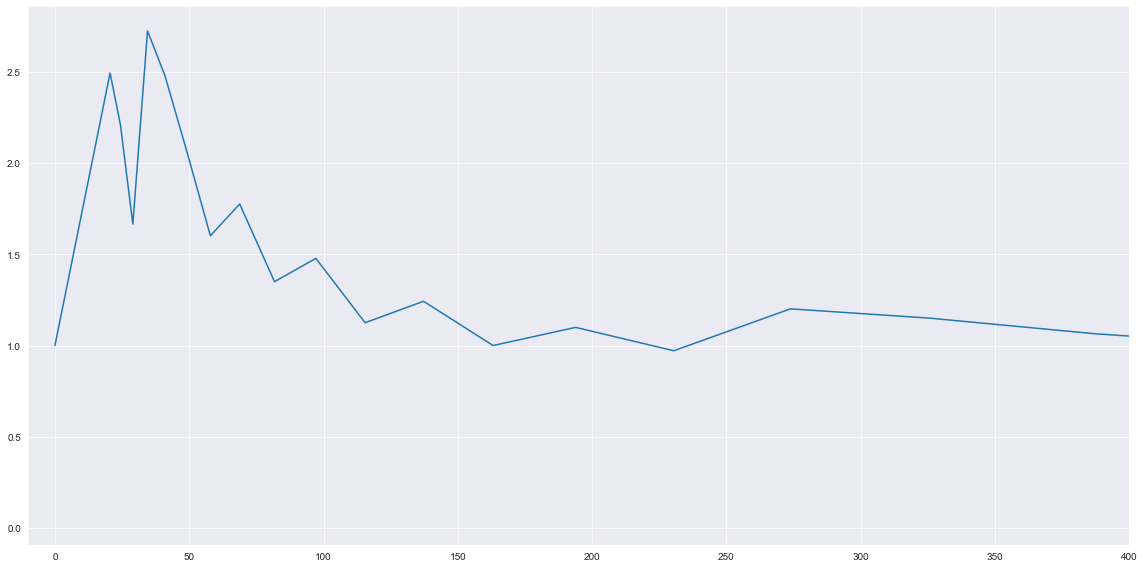

In [38]:
plt.plot(freq_smoothed_aug, filt_gains)
plt.xlim([-10, 400])
plt.tight_layout()

In [39]:
numtaps = 2049
taps = firwin2(numtaps, freq_smoothed_aug, filt_gains, fs=sr_ref)

In [40]:
w, h = freqz(taps, 1.0)
h_dB = 20 * np.log10(abs(h))
w_hz = w/max(w) * sr_ref/2

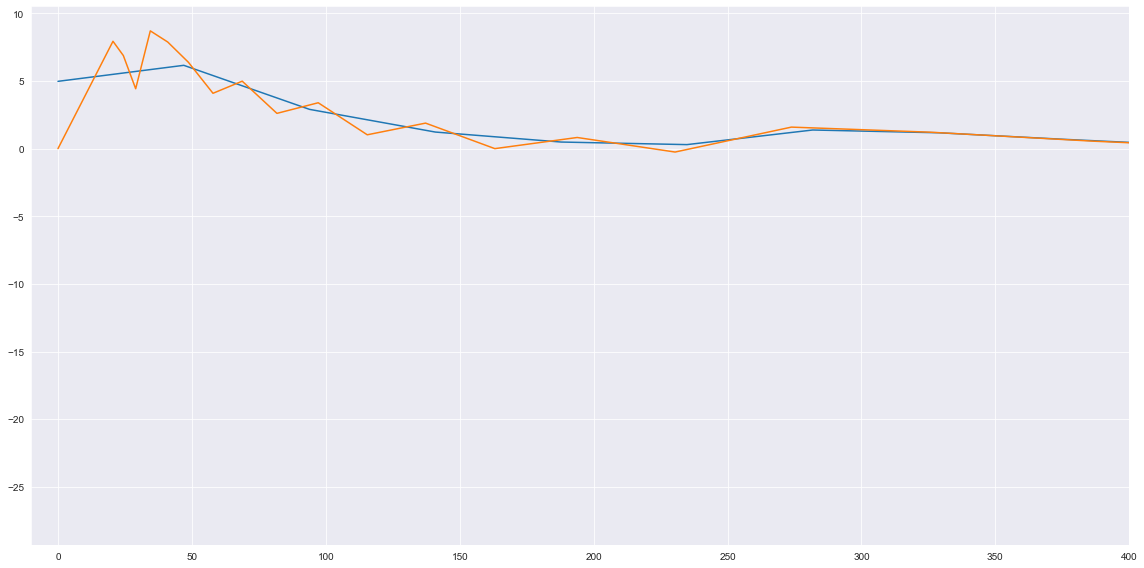

In [41]:
plt.plot(w_hz, h_dB, freq_smoothed_aug, magspec_db_smoothed_diff_aug)
plt.xlim([-10, 400])
plt.tight_layout()

In [42]:
b, a = utils.yulewalk(101, freq_smoothed_aug / np.max(freq_smoothed_aug), filt_gains)

In [43]:
w, h = freqz(b, a)
h_dB = 20 * np.log10(abs(h))
w_hz = w/max(w) * sr_ref/2

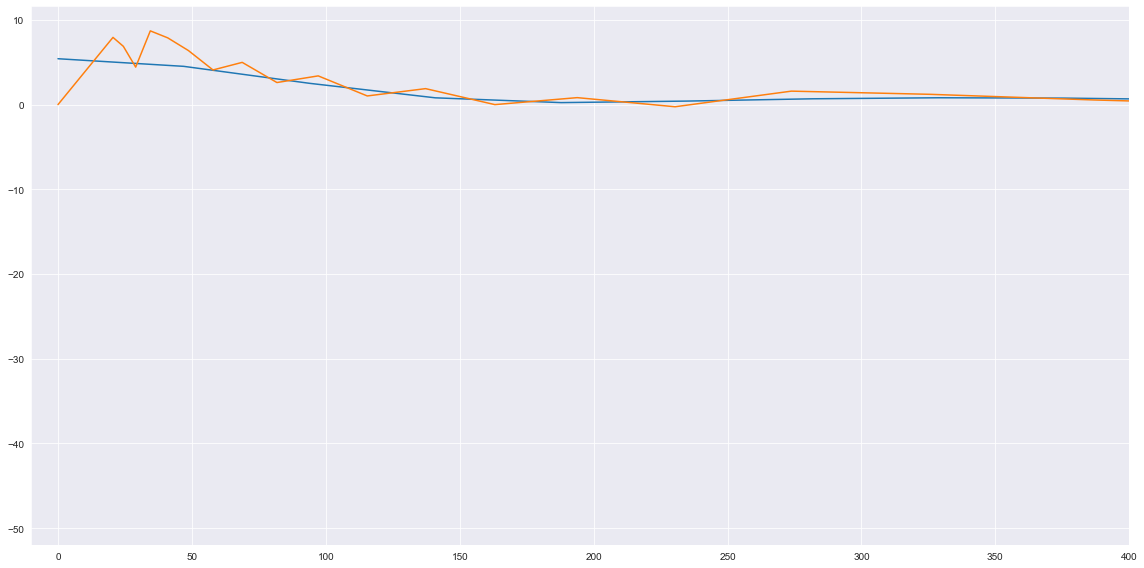

In [44]:
plt.plot(w_hz, h_dB, freq_smoothed_aug, magspec_db_smoothed_diff_aug)
plt.xlim([-10, 400])
plt.tight_layout()

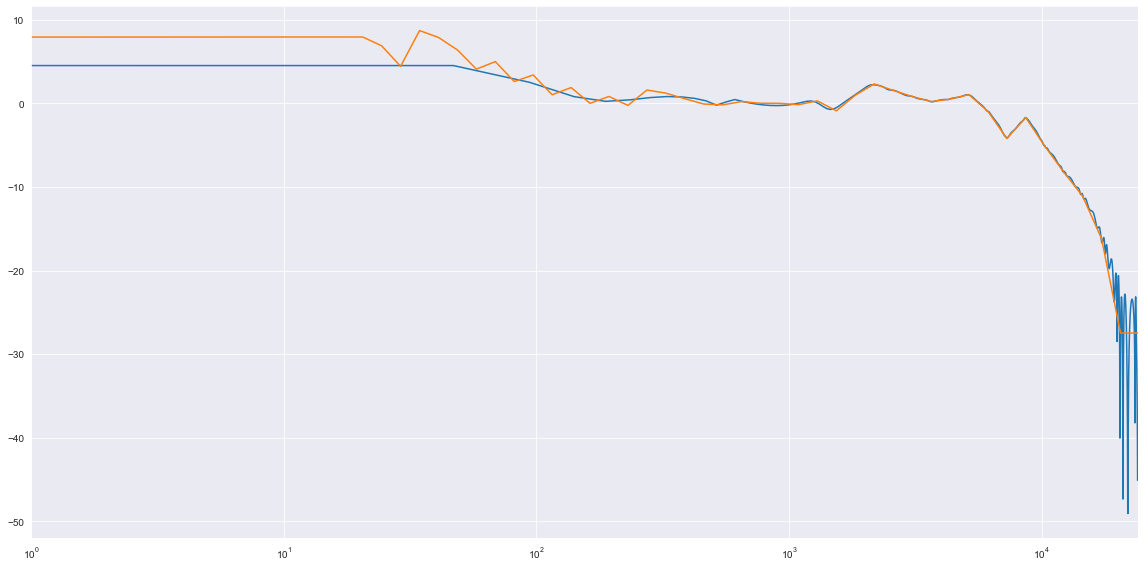

In [45]:
plt.semilogx(w_hz, h_dB, freq_smoothed_aug, magspec_db_smoothed_diff_aug)
plt.xlim([1, sr_ref/2])
plt.tight_layout()